# Section 4.1 Single Model Results Evaluation
*How can we evaluate and use the results of our Bayesian Inference model?*

In [25]:
import os
import time

import arviz as az
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import scipy.stats as stats

# os.chdir(os.path.join("..", "3_SinglePlotDiagnostics"))

np.random.seed(0)

NETCDF_DIR = "inference_data"

## Learning Objectives
* Use Posterior Plot and Forestplots to understand results of InferenceRun
* Summarize results numerically in Pandas Dataframe
* Generate and plot posterior predictive

## Back to statistics
In Section 2 and 3 we took a break from statistics to talk about data formats, and MCMC diagnostics. In this section we'll be getting back to a core question "what is my degree of belief given my observations?" or more colloquially "I saw a bunch of stuff, what do I actually know now?"

Recall that Bayesian Statistics gives us a distribution of beliefs, and not just a yes or no, or numerical answer. To interpret these results there's two often used plots

* Posterior Plot
* Forest Plot

Let's go through an example

## Noisy Linear Regression
Bayes Theorem is quite flexible and be applied in many ways, including regression. For our purposes let's simulate some data and see if we can recover the parameters through Bayesian Inference

Text(0.5, 0.98, 'Some Constant Noise Linearish Plot')

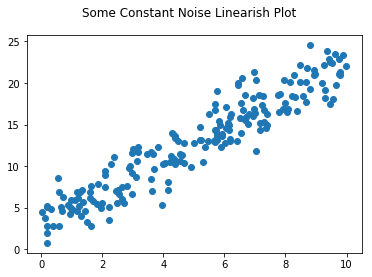

In [26]:
points = 200
x = np.random.uniform(0,10, points)

# Intercept
β = 3

# Slope
α = 2

# Constant Noise
ϵ =  stats.norm(loc=0, scale=2).rvs(size=points)
y = α*x + β + ϵ

# Plot observed data
fig, ax = plt.subplots()
ax.scatter(x,y)
fig.suptitle("Some Constant Noise Linearish Plot")

In [27]:
# Estimate parameters using Bayesian Inference
with pm.Model() as lin_constant_noise:
    # These Alpha and Beta are estimators for the givens above
    beta = pm.Normal("beta", 0,1)
    alpha = pm.Normal("alpha", 0,1)
    
    # Standard deviation can only be positive 
    epsilon = pm.HalfCauchy("epsilon", 1)
    
    y_est = pm.Normal("y_est", mu=alpha * x + beta, sd=epsilon, observed=y)
    
    trace = pm.sample(samples=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, alpha, beta]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:04<00:00, 1006.75draws/s]
The acceptance probability does not match the target. It is 0.711343678389321, but should be close to 0.8. Try to increase the number of tuning steps.


In [28]:
lin_constant_noise = az.from_pymc3(trace=trace)

Now that we have samples we can use plotting to see how well we did.

## Posterior Plot
Posterior plots, as the name suggests, visualize the posterior distribution from Inference Run

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1a98aa20>,
      dtype=object)

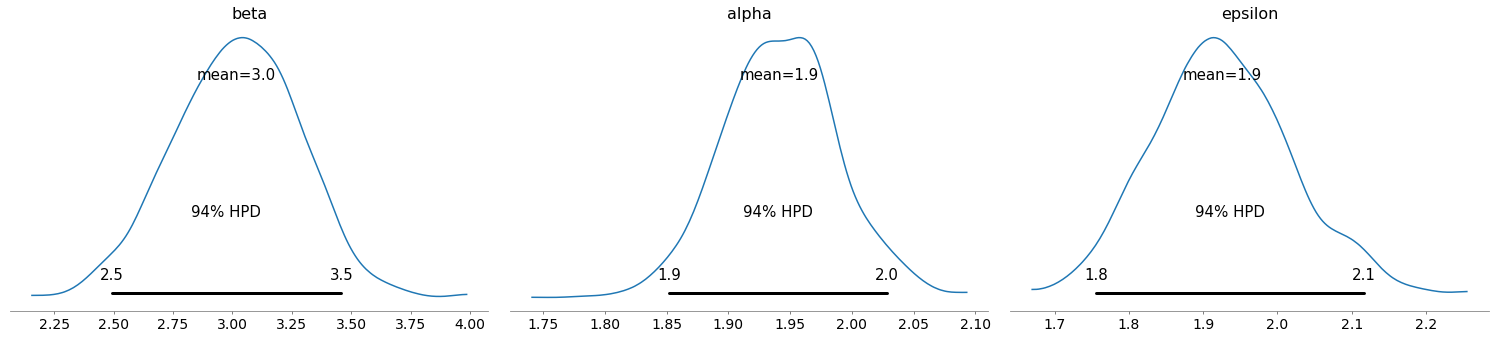

In [29]:
az.plot_posterior(trace)

Let's take a closer look at the plot of alpha.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c193e4320>],
      dtype=object)

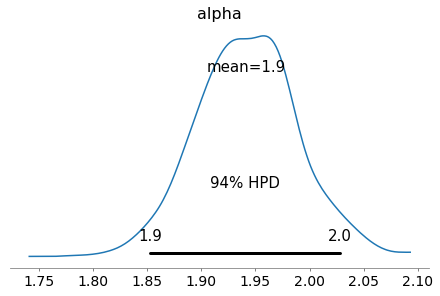

In [30]:
az.plot_posterior(trace, var_names=["alpha"])

At the most basic level a posterior plot helps us understand the distribution of possible parameters. In ArviZ a couple of other pieces of information come "for free" the Highest Posterior Density and a point estimate. Through these visualization and a couple of key points we can get an estimate.

In this case we get a median of alpha, and in our inference run are 94% sure that the true value lies in the range of 1.9 and 2.0

## Forest Plots
Posterior Plots are great viewing the details of one variable, but it can be challenging to compare the distributions of each as the scale is not shared for each x axis. ForestPlots make comparison of variables simpler, both their point estimate, and their uncertainty.

In the plot below we can see that the posterior for alpha (slope) is much narrow than the posterior for beta (intercept). Forestplots in ArviZ also include ess and r_hat for diagnostics for each variable, as well as statistical estimates for each chain.

(<Figure size 720x475.2 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1b64f588>,
       dtype=object))

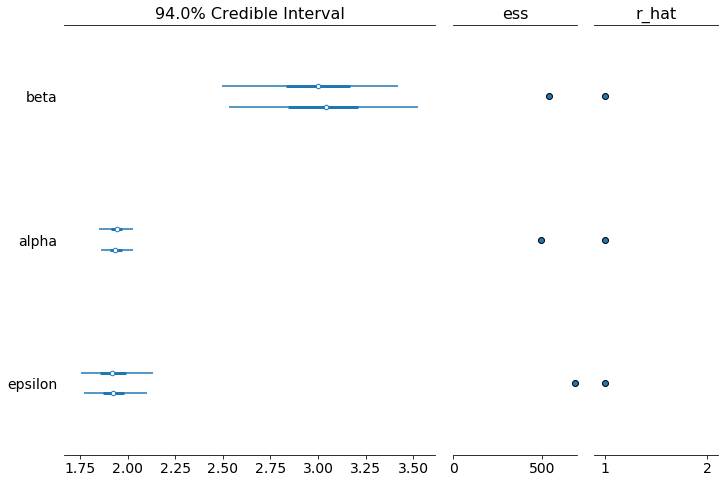

In [31]:
az.plot_forest(trace, ess=True, r_hat=True)

## Tabular Summary

In [38]:
az.summary(trace)

/Users/canyon/.miniconda3/envs/bayestutorial/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


,mean,sd,mc error,hpd 3%,hpd 97%,ess,r_hat
beta,2.97,0.04,0.0,2.90,3.03,1446.0,1.0
alpha,1.72,0.14,0.0,1.44,1.97,2154.0,1.0
epsilon,2.08,0.10,0.0,1.89,2.28,1432.0,1.0


ArviZ can also provide a numerical summary for a quick glance. I caution users to plot results first though, as posterior distributions could be multimodal, or non normal. If that is the case the mean and sd of the summary will be misleading.

## A Heteroscedastic Dataset

Let's try running our linear regression again, but this time let's add heteroscedastic noise, which is noise that increases over "time". 

Text(0.5, 0.98, 'Some Time Varying Noise Linearish Plot')

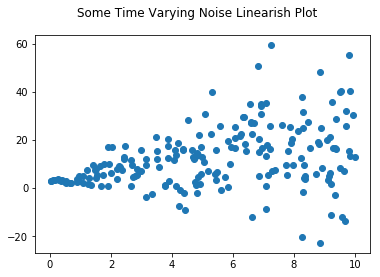

In [32]:
points = 200

# A bunch of random points 
x = np.random.uniform(0,10, points) 

# Intercept
β = 3

# Slope
α = 2

# Heteroscedastic Noise
ϵ =  stats.norm(loc=0, scale=2).rvs(size=points)
y = (α+ϵ)*x + β 

# Plot observed data
fig, ax = plt.subplots()
ax.scatter(x,y)
fig.suptitle("Some Time Varying Noise Linearish Plot")

After generating some data, we can visually "sense" that the intercept is fairly "defined" but as we move right things get more "spread out". We can use our Bayesian Modeling and visualization skills to quantify our feelings

In [33]:
# Estimate parameters using Bayesian Inference
with pm.Model() as lin_constant_noise:
    # These Alpha and Beta are estimators for the givens above
    beta = pm.Normal("beta", 0,1)
    alpha = pm.Normal("alpha", 0,1)
    
    # Standard deviation can only be positive 
    epsilon = pm.HalfCauchy("epsilon", 1)
    
    y_est = pm.Normal("y_est", mu=alpha*x + beta, sd=(epsilon*x), observed=y)
    
    trace = pm.sample(samples=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, alpha, beta]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1311.28draws/s]


In [34]:
time_varying_noise = az.from_pymc3(trace=trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1aa26320>,
      dtype=object)

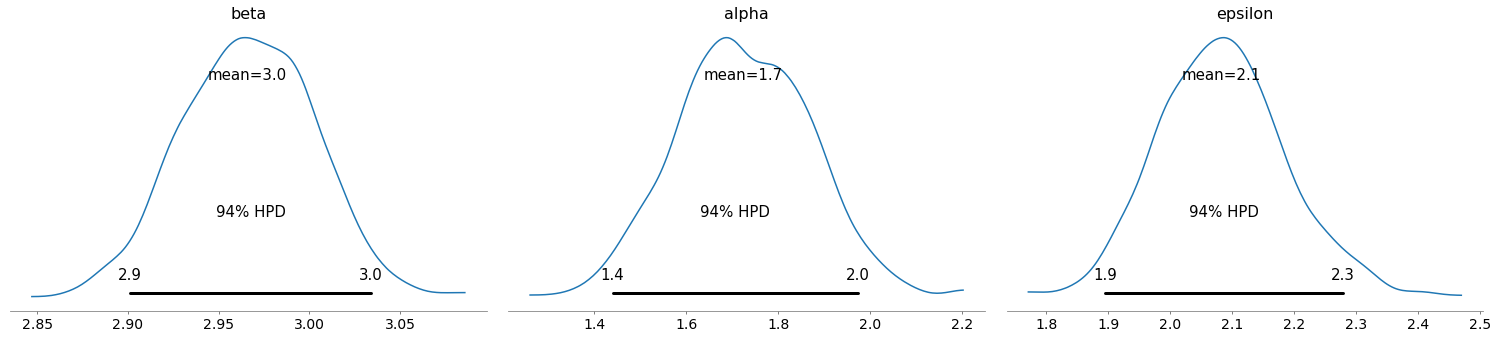

In [35]:
az.plot_posterior(time_varying_noise)

Using posterior plots we can see the distribution of the parameters and some point estimates again. This time note the distribution and HPD of beta. In our previous example beta had a wider HPD, versus in this dataset our feeling of certainty is reflected in a much smaller hpd.

(<Figure size 720x475.2 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1b9cacf8>,
       dtype=object))

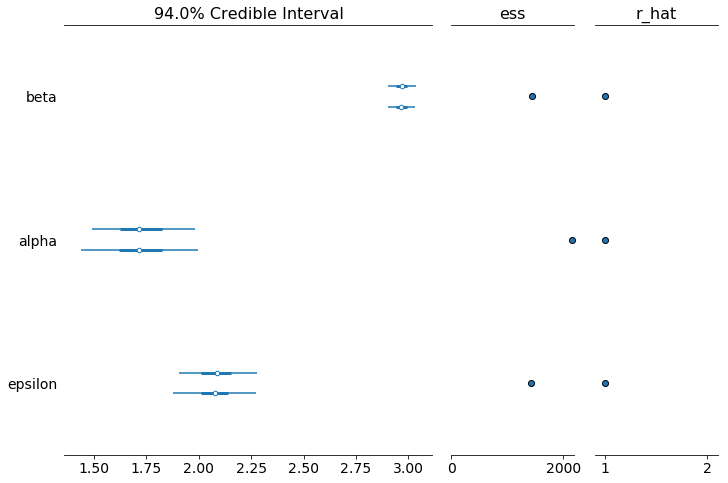

In [37]:
az.plot_forest(time_varying_noise, ess=True, r_hat=True)

We can again use forestplot to to visualize the uncertainty of each parameter. Note that this time alpha has a wider uncertainty than beta, which matches what we can intuit in our plots above.

## So what do I do with the results?
Unfortunately the unsatisfying answer is, it depends. but I can give some examples.

### Need to make a yes no answer
If you need to make a yes or no answer, similar to significance testing in frequentist statistics, John Kruschke provides a framework with [Region of Practical Equivalence](https://doingbayesiandataanalysis.blogspot.com/2013/08/how-much-of-bayesian-posterior.html).

### Need to make a business decision
I've (Ravin) have used posterior estimates to determine the probability something will happen. For example in manufacturing parts need to arrive by a certain date or a rocket ship is late. By estimating part lead time I can say that a part will arrive in 10 days or less with 80% of the time.

Posterior estimates can also be used with loss functions and quantitaive decision making. Thomas Wiecki and I wrote a blog post [detailing this method](http://canyon289.github.io/BayesianDecisionMaking.html#BayesianDecisionMaking) 

## Bad Inference Runs and Bad Models lead to bad decisions
While it may be tempting to write a quick model, kick off an MCMC run, and evaluate the results remember that if either the inference run or the model has problems, the posterior estimates will also have problems. So far we have covered how to diagnose inference runs, in Section 5 we will cover how to choose between different models.